## 🔮 Deep Learning in Practice


<img src="https://i.imgur.com/7sVPJqM.png">

## 🏗️ Building Models

Now we're ready to explore how to build models in Keras. Consider the following model we build earlier in PyTorch:
```python
import torch
import torch.nn as nn
import numpy as np

class DeepModel(nn.Module):                   # This used to be logistic regression (we lively modified it in the tutorial)
    def __init__(self):
        super(DeepModel, self).__init__()
        # 1. Define the layers
        self.l1 = nn.Linear(2, 1000)                   # have two input features
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(1000, 1)
        self.sigmoid = nn.Sigmoid()

        # 3. loss function
        self.criterion = nn.BCELoss()
        
        # 4. optimizer
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    def forward(self, x):
        # 2. Use the layers to shape the architecture
        a = self.sigmoid(self.l2(self.relu(self.l1(x))))
        return a
```

Building this in Keras is much like building a custom layer. In fact:

In [42]:
import tensorflow as tf
issubclass(tf.keras.Model, tf.keras.layers.Layer)

True

And we have indeed built a model by inheriting from `Layer` in the last notebook. The difference is that inheriting from `tf.keras.model` gives extra functionality such as instant fit and evaluate as we will see later:

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tqdm.notebook import tqdm 

class DeepModel(tf.keras.Model):
    def __init__(self):
        super(DeepModel, self).__init__()
        # Define the layers
        self.l1 = Dense(1000, input_shape=(2,), activation='relu')
        self.l2 = Dense(1, activation='sigmoid')

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()

        # Optimizer
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

    def call(self, x):
        # Use the layers to shape the architecture
        x = self.l1(x)
        x = self.l2(x)
        return x

Let's train it on the circles dataset as we did in PyTorch. So let's define the train/evaluate functions first:

In [44]:
AddToClass = lambda func: setattr(DeepModel, func.__name__, func) or func

@AddToClass
def train(self, train_dataset, num_epochs=300):
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        # 1. Setup metrics for epoch
        epoch_loss = tf.keras.metrics.Mean()
        for x_batch, y_batch in train_dataset:
            
            # 2. Forward pass and compute loss
            with tf.GradientTape() as tape:
                # next two lines just like PyTorch
                y_pred = self(x_batch, training=True)
                loss = self.loss_fn(y_batch, y_pred)
            
            # 3. Backward pass
            gradients = tape.gradient(loss, self.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            
             # 4. Update metrics
            epoch_loss.update_state(loss)
        pbar.set_description(f'Epoch {epoch + 1}, Loss: {round(float(epoch_loss.result()), 2)}')

@AddToClass
def predict(self, x_val):
    # No need to specify with torch.no_grad()
    predicted_probs = self(x_val)
    predicted_labels = tf.cast(predicted_probs > 0.5, tf.float32)
    return predicted_labels.numpy()

In [45]:
from sklearn.datasets import make_circles
from tensorflow.keras.utils import split_dataset

model = DeepModel()

# Generate synthetic dataset using make_blobs
X, y = make_circles(n_samples=700, noise=0.1, factor=0.5, random_state=42)
dataset = tf.data.Dataset.from_tensor_slices((X, y))
train_dataset, val_dataset = split_dataset(dataset, shuffle=True, seed=42, left_size=0.8)       # a better way to split with keras.utils

model.train(train_dataset.batch(32), num_epochs=300)

  0%|          | 0/300 [00:00<?, ?it/s]

Let's look at the decision boundary.

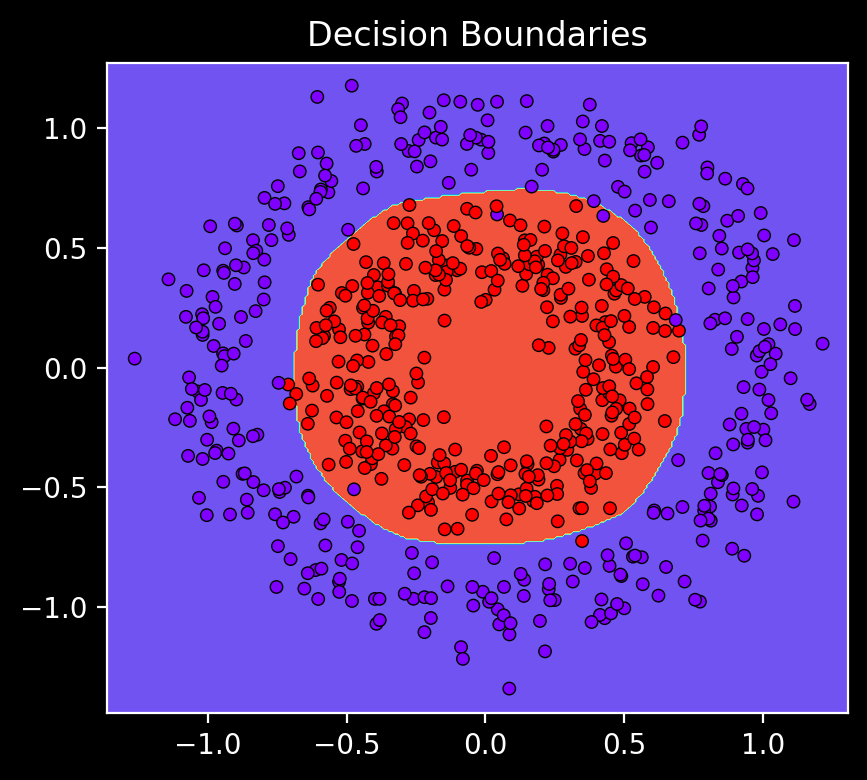

In [46]:
from Plot import plot_model_contours
plot_model_contours(model, X, y, trained=True)

### 🚀 High-level Training and Evaluation

Keras models already support built-in `fit`, `evaluate`, `predict`, `save`, `load_weights` functions. That is, we did not need to implement `train` and `predict` (however, in the general case, you need to modify training and prediction logic so that's why we started with it). See [this](https://keras.io/api/models/model_training_apis/) for the supported functions.

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense

class DeepModel(tf.keras.Model):
    def __init__(self):
        super(DeepModel, self).__init__()
        # Define the layers
        self.l1 = Dense(10000, input_shape=(2,), activation='relu')
        self.l2 = Dense(1, activation='sigmoid')

    def call(self, x):
        # Use the layers to shape the architecture
        x = self.l1(x)
        x = self.l2(x)
        return x
    
# Loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()
# Optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
# Metric
accuracy = tf.keras.metrics.Accuracy()

# Instantiate model
model = DeepModel()

# You will have to specify the loss, optimizer, and metrics with compile()
model.compile(loss=loss_fn, optimizer=optimizer, metrics=[accuracy], run_eagerly=True)    # set run_eagerly=False when not debugging

model.fit(train_dataset.batch(32), epochs=300)

Epoch 1/300
18/18 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.4607
Epoch 2/300
18/18 [==============================] - 0s 1ms/step - loss: 0.6908 - accuracy: 0.4964
Epoch 3/300
18/18 [==============================] - 0s 1ms/step - loss: 0.6892 - accuracy: 0.4964
Epoch 4/300
18/18 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.4964
Epoch 5/300
18/18 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.4964
Epoch 6/300
18/18 [==============================] - 0s 2ms/step - loss: 0.6844 - accuracy: 0.4964
Epoch 7/300
18/18 [==============================] - 0s 1ms/step - loss: 0.6828 - accuracy: 0.4964
Epoch 8/300
18/18 [==============================] - 0s 1ms/step - loss: 0.6813 - accuracy: 0.4964
Epoch 9/300
18/18 [==============================] - 0s 1ms/step - loss: 0.6798 - accuracy: 0.4964
Epoch 10/300
18/18 [==============================] - 0s 1ms/step - loss: 0.6783 - accuracy: 0.4964
Epoch 11/

### 🤙 Callbacks

Default output format clearly not nice. This is one application for callbacks!

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

In [48]:
from tqdm.keras import TqdmCallback
model.fit(train_dataset.batch(32), epochs=300, callbacks=[TqdmCallback()], verbose=False)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [49]:
model.evaluate(val_dataset.batch(32), return_dict=True)

5/5 [==============================] - 0s 1ms/step - loss: 0.1180 - accuracy: 0.9929


{'loss': 0.11803548038005829, 'accuracy': 0.9928571581840515}

A more interesting callback is `EarlyStopping` which will stop training the model whenever further reducing training loss leads to an increase in validation loss for `patience` number of epochs.

In [50]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [TqdmCallback(), EarlyStopping(monitor='val_loss', patience=2)]
model.fit(train_dataset.batch(32), epochs=300, callbacks=callbacks, validation_data=val_dataset.batch(32), verbose=False)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Seems like overfitting this particular dataset isn't as easy (it's not that noisy). 

Now let's save the model:

In [51]:
model.save('deep_model.tf')  # HDF5 format

INFO:tensorflow:Assets written to: deep_model.tf/assets


INFO:tensorflow:Assets written to: deep_model.tf/assets


Then load it

In [52]:
from tensorflow.keras.models import load_model
loaded_model = load_model('deep_model.tf')
loaded_model.summary()

Model: "deep_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            multiple                  30000     
                                                                 
 dense_21 (Dense)            multiple                  10001     
                                                                 
Total params: 40001 (156.25 KB)
Trainable params: 40001 (156.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 🤔 Mid-level Training API?

We have seen that we can use Keras's default training/prediction/evaluation function (high-level) or define our own (low-level). It's also possible to only define the body of the training loop in the class definition of your model:
```python
def train_step(self, data):
        xb, yb = data
        # body of the training loop (i.e., what logic to do for each batch)
```
We won't continue with an example but remember it exists if you ever need it. See an example [here](https://keras.io/guides/custom_train_step_in_tensorflow/).

### 💡 High-level Model Definition

Support for `Sequential` exists like PyTorch (when your layers all have single I/O).

In [54]:
from tensorflow.keras.models import Sequential

model = Sequential([
    Dense(10000, input_shape=(2,), activation='relu'),
    Dense(1, activation='sigmoid')
])
# can also get rid of the last layer then write the line: model.add(Dense(1, activation='sigmoid'))

Also for high-level fans, you don't need to instantiate objects for your loss, optimizer and metrics if their default hyperparameters just work fine for you:

In [55]:
# For high-level fans, this is also equivalent to:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])  

Let's train and test:

In [56]:
from tqdm.keras import TqdmCallback
model.fit(train_dataset.batch(32), epochs=300, callbacks=[TqdmCallback()], verbose=False)
model.evaluate(val_dataset.batch(32), return_dict=True)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

5/5 [==============================] - 0s 1ms/step - loss: 0.2791 - accuracy: 0.9857


{'loss': 0.27905452251434326, 'accuracy': 0.9857142567634583}

### 💫 Functional API

So far, we have seen three ways to train your model in Keras and two ways to construct your model. There is actually a third way to define your model and it's actually the most common among Keras users:

In [59]:
from tensorflow.keras.models import Model

# Define the input
inputs = tf.keras.Input(shape=(2,))             # does not come from keras.layers because input layer is not really a layer

# Define the architecture and pass input simultaneously
a = Dense(10000, activation='relu')(inputs)     # in the class case, we defined layers in init and used in call
outputs = Dense(1, activation='sigmoid')(a)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])  

In [60]:
from tqdm.keras import TqdmCallback
model.fit(train_dataset.batch(32), epochs=300, callbacks=[TqdmCallback()], verbose=False)
model.evaluate(val_dataset.batch(32), return_dict=True)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

5/5 [==============================] - 0s 1ms/step - loss: 0.2785 - accuracy: 0.9857


{'loss': 0.27854645252227783, 'accuracy': 0.9857142567634583}

It may be that the functional API is more supported than the class API (e.g., when needing advanced features).

### 🏎️ Keras Tuner

In [65]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import keras_tuner as kt

# Keras tuner assumes you construct your model as a function like so:
def build_model(hp):
    # Define the input layer
    inputs = tf.keras.Input(shape=(2,))
    
   # Define the architecture and pass input simultaneously
    x = Dense(
              units=hp.Int('units', min_value=1000, max_value=10000, step=1000), 
              activation=hp.Choice("activation", ["relu", "tanh"]),
              )(inputs)      
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(
        optimizer=SGD(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 1. Initialize the tuner (here we use the Hyperband tuner)
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,                   # related to Hyperband algorithm iterations
    directory='tuning_dir',
    project_name='cmp'
)
# Hyperband uses Asynchronous Successive Halving Algorithm (ASHA), 
# a strategy that massively parallelizes hyperparameter tuning and automatically stops training jobs early 
# by using previously evaluated configurations to predict whether a specific candidate is promising or not.

# Search for the best hyperparameters
tuner.search(train_dataset.batch(32), validation_data=val_dataset.batch(32))

# Retrieve the best model
best_model = tuner.get_best_models()[0]
best_model.summary()

Trial 87 Complete [00h 00m 02s]
val_accuracy: 0.5142857432365417

Best val_accuracy So Far: 0.9928571581840515
Total elapsed time: 00h 01m 13s


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2000)              6000      
                                                                 
 dense_1 (Dense)             (None, 1)                 2001      
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 1000, 'max_value': 10000, 'step': 1000, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1], 'ordered': True}


In [67]:
tuner.results_summary()

Results summary
Results in tuning_dir/cmp
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0050 summary
Hyperparameters:
units: 2000
activation: relu
learning_rate: 0.1
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0046
Score: 0.9928571581840515

Trial 0051 summary
Hyperparameters:
units: 6000
activation: relu
learning_rate: 0.1
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0047
Score: 0.9928571581840515

Trial 0072 summary
Hyperparameters:
units: 1000
activation: relu
learning_rate: 0.1
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0067
Score: 0.9928571581840515

Trial 0073 summary
Hyperparameters:
units: 7000
activation: relu
learning_rate: 0.1
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0068
Score: 0.9928571581840515

Trial 0082 summary
Hyperparameters:
units: 5000
activation: relu
l

<img src="https://i.imgur.com/0OQVA5H.png">